In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    df = pd.read_csv('/content/Advertising.csv')
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)

    print("--- Dataset Loaded Successfully ---")
    print("Dataset Shape:", df.shape)
    print("\n--- First 5 Rows ---")
    print(df.head())

except FileNotFoundError:
    print("Error: 'Advertising.csv' not found. Please download it from Kaggle and place it in the correct directory.")
    exit()

--- Dataset Loaded Successfully ---
Dataset Shape: (200, 4)

--- First 5 Rows ---
      TV  Radio  Newspaper  Sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3   12.0
3  151.5   41.3       58.5   16.5
4  180.8   10.8       58.4   17.9



--- Data Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB

--- Descriptive Statistics ---
               TV       Radio   Newspaper       Sales
count  200.000000  200.000000  200.000000  200.000000
mean   147.042500   23.264000   30.554000   15.130500
std     85.854236   14.846809   21.778621    5.283892
min      0.700000    0.000000    0.300000    1.600000
25%     74.375000    9.975000   12.750000   11.000000
50%    149.750000   22.900000   25.750000   16.000000
75%    218.825000   36.525000   45.100000   19.050000
max    296.400000   49.600000  114.000000   27.000000

--- Checking for Missing Values ---
TV           0
Radio        0
Newsp

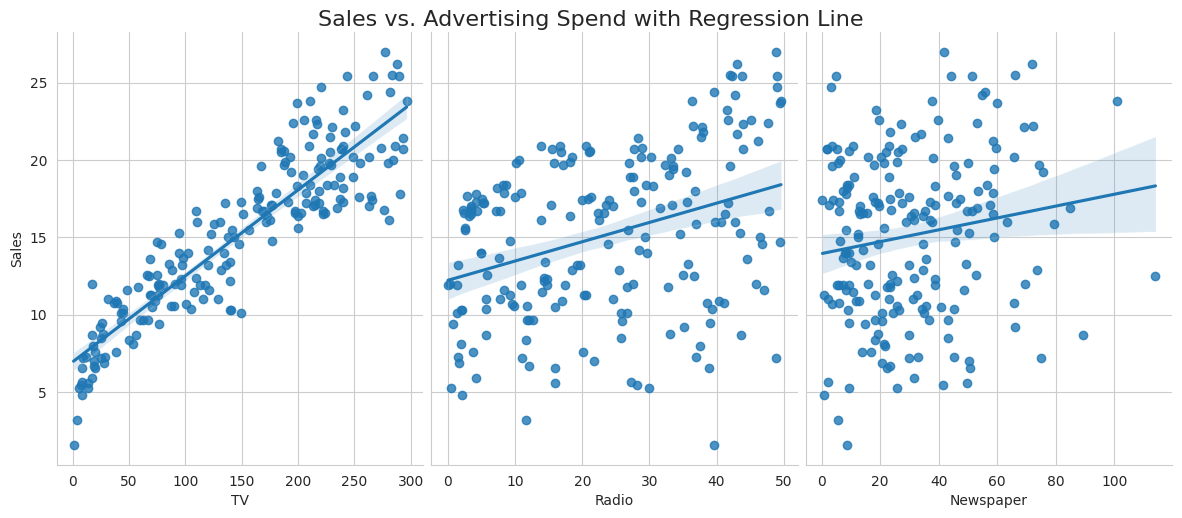

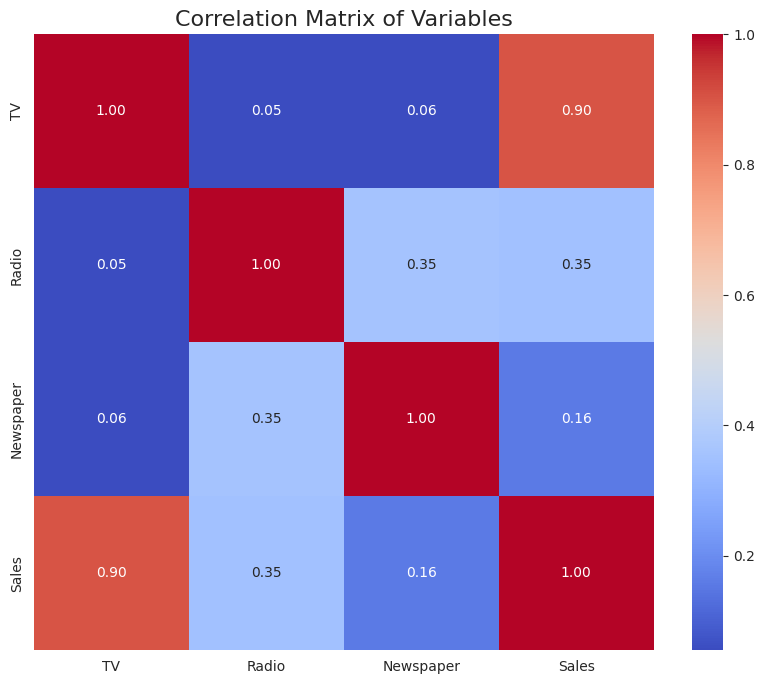

In [2]:
print("\n--- Data Information ---")
df.info()
print("\n--- Descriptive Statistics ---")
print(df.describe())
print("\n--- Checking for Missing Values ---")
print(df.isnull().sum())

sns.set_style("whitegrid")

# 1. Visualize Relationships and Distributions
print("\nGenerating pairplot to visualize variable relationships...")
sns.pairplot(df, x_vars=['TV', 'Radio', 'Newspaper'], y_vars='Sales', height=5, aspect=0.8, kind='reg')
plt.suptitle('Sales vs. Advertising Spend with Regression Line', y=1.02, fontsize=16)
plt.show()

# 2. Correlation Heatmap

plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Variables', fontsize=16)
plt.show()

In [5]:
df['TV_Radio_Interaction'] = df['TV'] * df['Radio']

df['TV_sq'] = df['TV']**2
df['Radio_sq'] = df['Radio']**2

df['Total_Spend'] = df['TV'] + df['Radio'] + df['Newspaper']

# Calculate shares using standard pandas operations to avoid RecursionError
df['TV_Share'] = df['TV'] / df['Total_Spend']
df['Radio_Share'] = df['Radio'] / df['Total_Spend']

df_engineered = df.drop(['Newspaper', 'Total_Spend'], axis=1)

print("--- DataFrame with New Engineered Features ---")
print(df_engineered.head())

--- DataFrame with New Engineered Features ---
      TV  Radio  Sales  TV_Radio_Interaction     TV_sq  Radio_sq  TV_Share  \
0  230.1   37.8   22.1               8697.78  52946.01   1428.84  0.682587   
1   44.5   39.3   10.4               1748.85   1980.25   1544.49  0.345229   
2   17.2   45.9   12.0                789.48    295.84   2106.81  0.129909   
3  151.5   41.3   16.5               6256.95  22952.25   1705.69  0.602865   
4  180.8   10.8   17.9               1952.64  32688.64    116.64  0.723200   

   Radio_Share  
0     0.112133  
1     0.304888  
2     0.346677  
3     0.164345  
4     0.043200  


In [6]:
from sklearn.model_selection import train_test_split

X = df_engineered.drop('Sales', axis=1)
y = df_engineered['Sales']

feature_names = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nData split complete.")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Data split complete.
Training set shape: (160, 7)
Testing set shape: (40, 7)


In [7]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print("\n--- Training Baseline XGBoost Model ---")
base_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
base_xgb.fit(X_train, y_train)
y_pred_base = base_xgb.predict(X_test)
r2_base = r2_score(y_test, y_pred_base)
print(f"Baseline XGBoost R² Score: {r2_base:.4f}")

print("\n--- Optimizing XGBoost with GridSearchCV ---")

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=base_xgb,
                           param_grid=param_grid,
                           scoring='r2',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters found: {grid_search.best_params_}")

final_model = grid_search.best_estimator_

y_pred_final = final_model.predict(X_test)

final_r2 = r2_score(y_test, y_pred_final)
final_mae = mean_absolute_error(y_test, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))

print("\n--- Final Optimized Model Performance ---")
print(f"Final Tuned R² Score: {final_r2:.4f}")
print(f"Mean Absolute Error (MAE): {final_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {final_rmse:.2f}")


--- Training Baseline XGBoost Model ---
Baseline XGBoost R² Score: 0.9637

--- Optimizing XGBoost with GridSearchCV ---
Fitting 5 folds for each of 768 candidates, totalling 3840 fits

Best parameters found: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.7}

--- Final Optimized Model Performance ---
Final Tuned R² Score: 0.9610
Mean Absolute Error (MAE): 0.75
Root Mean Squared Error (RMSE): 1.10



--- Feature Importance from Final Model ---
                Feature  Importance
3                 TV_sq    0.514998
0                    TV    0.355855
2  TV_Radio_Interaction    0.087917
1                 Radio    0.021333
5              TV_Share    0.007445
4              Radio_sq    0.007163
6           Radio_Share    0.005290


/tmp/ipython-input-8-1620410334.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


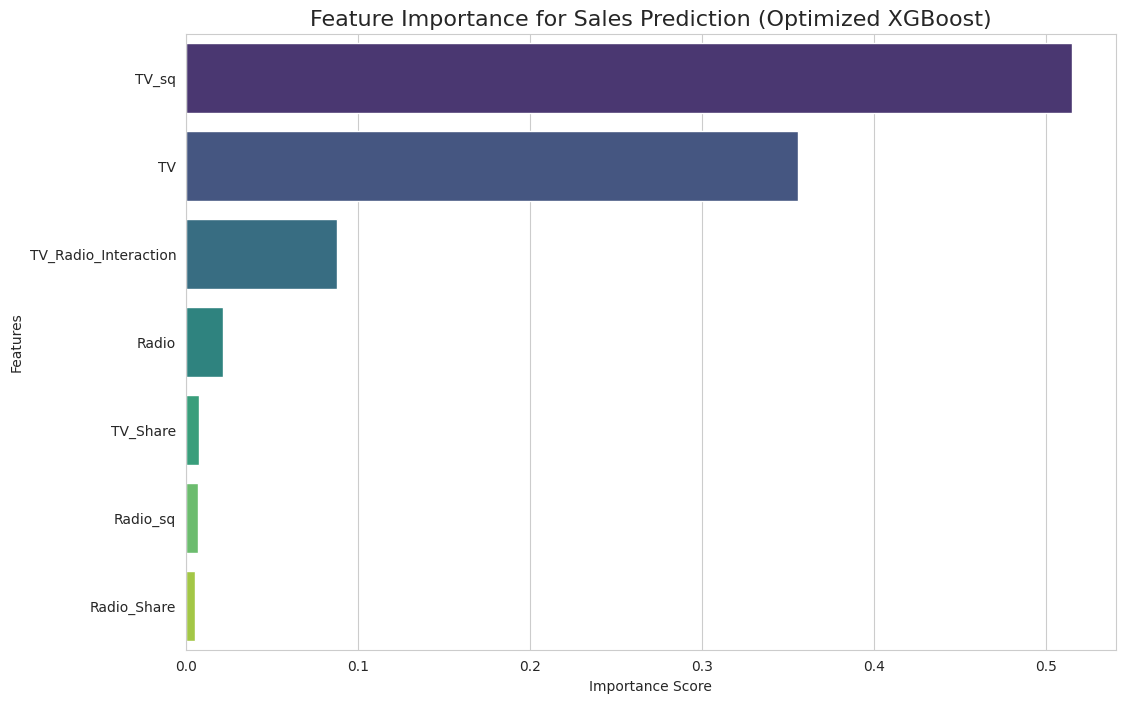

In [8]:
importances = final_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n--- Feature Importance from Final Model ---")
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance for Sales Prediction (Optimized XGBoost)', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


In [14]:
import joblib
joblib.dump(final_model, 'optimized_xgb_model.pkl')
print("\nFinal model saved as 'optimized_xgb_model.pkl'")
feature_names = X_train.columns.tolist()
joblib.dump(feature_names, 'feature_names.pkl')
print("Feature names saved as 'feature_names.pkl'")


Final model saved as 'optimized_xgb_model.pkl'
Feature names saved as 'feature_names.pkl'


In [19]:
import os
import joblib

MODEL_DIR = '../model'
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

# Define file paths
MODEL_PATH = os.path.join(MODEL_DIR, 'optimized_xgb_model.pkl')
FEATURES_PATH = os.path.join(MODEL_DIR, 'feature_names.pkl')

# Save the final model
joblib.dump(final_model, MODEL_PATH)
print(f"\nFinal model saved to: {MODEL_PATH}")

# Save the feature names list
joblib.dump(feature_names, FEATURES_PATH)
print(f"Feature names saved to: {FEATURES_PATH}")



Final model saved to: ../model/optimized_xgb_model.pkl
Feature names saved to: ../model/feature_names.pkl

--- Notebook execution complete. You can now run the Streamlit app. ---
